In [40]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
  
import tensorflow as tf

slim = tf.contrib.slim

# import vgg
# import vgg16_coord_model as model
import numpy as np
import pandas as pd
import sklearn.model_selection as sk
from enum import Enum
import sys
import time

import importlib
import helper_function
import train_input
import cpm
importlib.reload(train_input)
importlib.reload(helper_function)
importlib.reload(cpm)

<module 'cpm' from 'C:\\Users\\csyic\\work\\fashion\\cpm.py'>

In [4]:
class Config():

  # =================== modify parameters ==================
  TAG = "_demo" # used for uniform filename
               # "_demo": train with demo images
               # "": (empty) train with ~60000 images
  batch_size = 20
  initialize = True # True: train from scratch (should also
                    # delete the corresponding params files
                    # in params_dir);
                     # False: restore from pretrained model
  steps = "30000"   # if 'initialize = False', set steps to 
                     # where you want to restore
  toDistort = False
  # iterations config
  max_iteration = 30000
  checkpoint_iters = 2000
  summary_iters = 100
  validate_iters = 2000
  # ========================================================

  annos_path = "./labels/txt/input/train_annos" + TAG + ".txt"
  data_path = "./data/input/train_imgs" + TAG + "/"
  gpu = '/gpu:0'

  # checkpoint path and filename
  logdir = "./log/train_log/"
  params_dir = "./params/" + TAG + "/"
  load_filename = "cpm" + '-' + steps
  save_filename = "cpm"

  # image config
  points_num = 4
  fm_channel = points_num + 1
#   origin_height = 212
#   origin_width = 256
  img_height = 256
  img_width = 256
  is_color = False

  # feature map config
  fm_width = img_width >> 1
  fm_height = img_height >> 1
  sigma = 2.0
  alpha = 1.0
  radius = 12

  # random distortion
  degree = 8

  # solver config
  wd = 5e-4
  stddev = 5e-2
  use_fp16 = False
  moving_average_decay = 0.999

In [31]:
imsize = 256
total_size = 20
category_name = "skirt"


In [34]:

x_input,y_input = train_input.get_x_y_map(total_size,512/imsize, cates = category_name, flat_x = False)

Read data from files:  train_pad/Annotations/train_skirt_coord_augs.csv
X shape:  (20, 256, 256, 3) Y shape:  (20, 31, 31, 4)


(array([], dtype=int64), array([], dtype=int64))

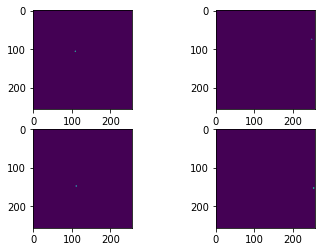

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(nrows=2, ncols=2)
for i_r,row in enumerate(ax):
    for i_c , col in enumerate(row):
        col.imshow(y_input[3,:,:,i_r+i_c*2],origin='upper')



a = y_input[3,:,:,3]
np.where(a==1)

212.0 219.0
294.0 223.0
150.0 494.0
304.0 505.0


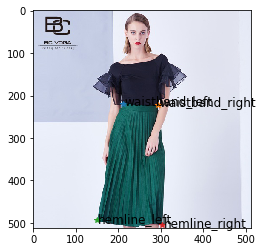

In [8]:

pre_dir = "./train_pad/"
df = pd.read_csv(pre_dir +"Annotations/train_"+category_name + ".csv")
helper_function.show_im_lms(df=df,index=3,pre_dir=pre_dir,scale=int(512/512))

In [41]:
tf.reset_default_graph()
config = Config()
model = cpm.CPM(config)
predict = model.inference_pose_v3()

loss = model.loss()
train_op = model.train_op(loss, model.global_step)

init_op = tf.global_variables_initializer()

Tensor("PoseNet/conv7_stage1/BiasAdd:0", shape=(20, 31, 31, 4), dtype=float32)
Tensor("PoseNet/Reshape:0", shape=(20, 3844), dtype=float32) Tensor("PoseNet/Reshape_1:0", shape=(20, 3844), dtype=float32)
Tensor("PoseNet/Reshape_2:0", shape=(20, 3844), dtype=float32) Tensor("PoseNet/Reshape_3:0", shape=(20, 3844), dtype=float32)
Tensor("PoseNet/Mconv5_stage2/BiasAdd:0", shape=(20, 31, 31, 4), dtype=float32) Tensor("PoseNet/Relu_14:0", shape=(20, 31, 31, 32), dtype=float32)
Tensor("PoseNet/Reshape_4:0", shape=(20, 3844), dtype=float32) Tensor("PoseNet/Reshape_5:0", shape=(20, 3844), dtype=float32)
INFO:tensorflow:Summary name total_loss (raw) is illegal; using total_loss__raw_ instead.


In [43]:
with tf.Session() as sess:
    sess.run(init_op)
    for i in range(10):
        feed_dict = {
                    model.images: x_input,
                    model.labels: y_input
                    }
        sess.run(train_op, feed_dict=feed_dict)

ResourceExhaustedError: OOM when allocating tensor with shape[20,128,127,127] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: gradients/PoseNet/MaxPool2D_4/MaxPool_grad/MaxPoolGrad = MaxPoolGrad[T=DT_FLOAT, data_format="NHWC", ksize=[1, 3, 3, 1], padding="VALID", strides=[1, 2, 2, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](PoseNet/Relu_7, PoseNet/MaxPool2D_4/MaxPool, gradients/PoseNet/conv3_stage2/Conv2D_grad/tuple/control_dependency)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: Adam/update_PoseNet/conv1_stage2/weights/ApplyAdam/_72 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1597_Adam/update_PoseNet/conv1_stage2/weights/ApplyAdam", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'gradients/PoseNet/MaxPool2D_4/MaxPool_grad/MaxPoolGrad', defined at:
  File "C:\Users\csyic\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\csyic\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\csyic\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\csyic\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\csyic\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\csyic\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\csyic\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-271adfda4d0b>", line 7, in <module>
    train_op = model.train_op(loss, model.global_step)
  File "C:\Users\csyic\work\fashion\cpm.py", line 537, in train_op
    grads = optimizer.compute_gradients(total_loss)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tensorflow\python\training\optimizer.py", line 456, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 609, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 375, in _MaybeCompile
    return grad_fn()  # Exit early
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 609, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_grad.py", line 583, in _MaxPoolGrad
    data_format=op.get_attr("data_format"))
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 3755, in _max_pool_grad
    data_format=data_format, name=name)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3160, in create_op
    op_def=op_def)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'PoseNet/MaxPool2D_4/MaxPool', defined at:
  File "C:\Users\csyic\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 18 identical lines from previous traceback]
  File "C:\Users\csyic\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-271adfda4d0b>", line 4, in <module>
    predict = model.inference_pose_v3()
  File "C:\Users\csyic\work\fashion\cpm.py", line 444, in inference_pose_v3
    pool2_stage2 = layers.max_pool2d(conv2_stage2, 3, 2)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tensorflow\contrib\framework\python\ops\arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tensorflow\contrib\layers\python\layers\layers.py", line 2170, in max_pool2d
    outputs = layer.apply(inputs)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tensorflow\python\layers\base.py", line 762, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tensorflow\python\layers\base.py", line 652, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tensorflow\python\layers\pooling.py", line 273, in call
    data_format=utils.convert_data_format(self.data_format, 4))
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 2043, in max_pool
    name=name)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 3459, in _max_pool
    data_format=data_format, name=name)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\csyic\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3160, in create_op
    op_def=op_def)

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[20,128,127,127] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: gradients/PoseNet/MaxPool2D_4/MaxPool_grad/MaxPoolGrad = MaxPoolGrad[T=DT_FLOAT, data_format="NHWC", ksize=[1, 3, 3, 1], padding="VALID", strides=[1, 2, 2, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](PoseNet/Relu_7, PoseNet/MaxPool2D_4/MaxPool, gradients/PoseNet/conv3_stage2/Conv2D_grad/tuple/control_dependency)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: Adam/update_PoseNet/conv1_stage2/weights/ApplyAdam/_72 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1597_Adam/update_PoseNet/conv1_stage2/weights/ApplyAdam", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

